# Get started with creating Speaker Recognition Project

To do:
* Normalize signal by energy
* Maybe crop end of files if noise. Apply smoothening filter if air conditioning is present.

## Convert m4a files to wav

In [ ]:
# ! pip install librosa #didnt work
# ! pip install ffmpeg #didnt work
# ! pip install pathlib
# ! pip install ffprobe
# ! pip install pydub
# ! pip install pandas

In [2]:
from pathlib import Path
from glob import glob

data_folder = Path().resolve() / "Audio Files"

twelve_test_files = glob(f'{data_folder}\Twelve Test\*.m4a')
twelve_train_files = glob(f'{data_folder}\Twelve Train\*.m4a')
zero_test_files = glob(f'{data_folder}\Zero Test\*.m4a')
zero_train_files = glob(f'{data_folder}\Zero Train\*.m4a')

In [10]:
from pydub import AudioSegment

for file_group in [twelve_test_files, twelve_train_files, zero_test_files, zero_train_files]:
  for file in file_group:
    sound = AudioSegment.from_file(file, format='m4a')
    sound.export(f'{file[:-4]}.wav', format='wav')


## Read in Wave files

In [2]:
from pathlib import Path
from glob import glob

data_folder = Path().resolve() / "Audio Files"

twelve_test_files = glob(f'{data_folder}\Twelve Test\*.wav')
twelve_train_files = glob(f'{data_folder}\Twelve Train\*.wav')
zero_test_files = glob(f'{data_folder}\Zero Test\*.wav')
zero_train_files = glob(f'{data_folder}\Zero Train\*.wav')

In [4]:
from scipy.io import wavfile
import numpy as np

# Specify the path to the WAV file
file_path = twelve_train_files[0] #twelve_test_files[0]

# Read the WAV file and store the sample rate and audio data
sample_rate, audio_data = wavfile.read(file_path)

# Convert the audio data to a NumPy array
audio_array = np.array(audio_data)

# Print the sample rate and shape of the audio array
print("Sample Rate:", sample_rate)
print("Audio Array Shape:", audio_array.shape)
print("Filename:", file_path)

Sample Rate: 48000
Audio Array Shape: (64512,)
Filename: C:\Users\randa\OneDrive - University of California, Davis\Documents\Davis\2024 Winter\EEC201\Speaker-Recognition\Audio Files\Twelve Train\Twelve_train1.wav


In [3]:
from IPython.display import Audio

# Play the audio array
Audio(audio_array, rate=sample_rate)

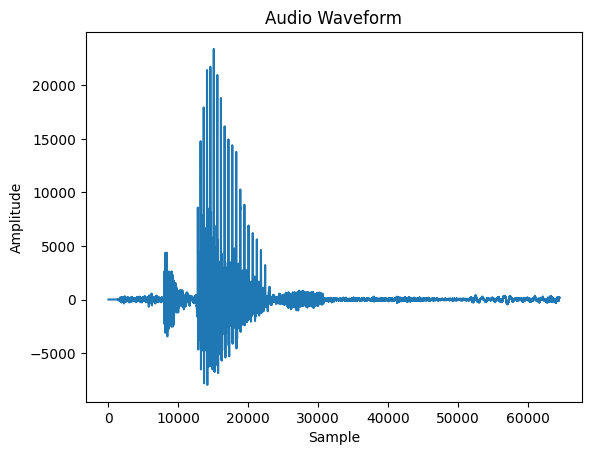

In [3]:
import matplotlib.pyplot as plt

# Plot the waveform
plt.plot(audio_array)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()


## Frame Blocking

In [15]:
from librosa.feature import mfcc, melspectrogram 
from librosa.filters import mel
from librosa.core import power_to_db
# import matplotlib.pyplot as plt

N = 1024#256  # Number of samples per frame # Change to 30ms window N = 0.03 * sample_rate
M = 512#100  # Number of samples between the start of each frame # Change to 18ms shift M = 0.01 * sample_rate
K = 20  # Number of Mel filters

speaker_mfccs = np.zeros((1 + (len(audio_array) - N + 1)//M, K))    # (samples, dimensions of a given sample)
print(speaker_mfccs.shape)
#mel_weights = np.zeros((K, N//2 + 1)) # Mel filter weights for getting mel spectrum

# freq = np.linspace(0, sample_rate/2, N//2 + 1)  # Frequency axis up to the Nyquist frequency

# Iterate over the audio array with the moving window
for i, sample in enumerate(range(0, len(audio_array) - N + 1, M)):
#for i in [800]:
    frame = audio_array[sample:sample+N]

    # Apply windowing to the frame
    windowed_frame = frame * np.hamming(N)  # Hamming window

    # Perform the Fourier transform
    X = np.fft.fft(windowed_frame)[:N//2 + 1]

    # plt.plot(freq, np.abs(X))
    # plt.xlabel('Frequency [Hz]')
    # plt.ylabel('Magnitude')
    # plt.title('Magnitude Spectrum')
    # plt.show()
    
    # Create Mel-Spectrum
    #speaker_mfccs[i,:] = np.transpose(mfcc(y=windowed_frame, sr=sample_rate, n_mfcc=K)) #S=librosa.power_to_db(np.abs(X)), n_mfcc=13)
    mel_spec = melspectrogram(y=windowed_frame, sr=sample_rate, n_mels=K, hop_length=N+1)  # Hop length needs to be N+1 to get 1 frame
    mel_spec_db = power_to_db(mel_spec)
    mel_cc = mfcc(S=mel_spec_db, n_mfcc=K)
    speaker_mfccs[i,:] = np.transpose(mel_cc)
    # Print the shape of the MFCC coefficients
    # print("MFCC Coefficients Shape:", mfcc_coef.shape)
    # print(type(mfcc_coef))
    pass
    
    

(125, 20)


ValueError: could not broadcast input array from shape (2,20) into shape (20,)

In [13]:
print(len(windowed_frame))
print(N)

1024
1024


## Codebook

In [5]:
from codebook import Codebook

# Generate a codebook for the MFCC coefficients
codebook = Codebook(speaker_mfccs, 32, verbose=True)

Iteration 1: 2 centroids, distortion = 73335.26235941143
	Error: 0.1214126941743348
	Codebook: [array([ 5.38766647e+02,  1.30298190e+02,  2.47224216e+01,  3.18723852e+01,
       -4.71660630e-01,  1.12965727e+01, -2.07805705e+01,  2.22945717e+01,
        1.49804814e+00,  2.90832901e+00, -8.68753878e+00,  1.01253721e+01,
       -1.29662808e+01,  1.58505722e+01, -1.02831371e+01,  1.07888828e+01,
       -8.52532122e+00,  7.36439359e+00, -4.41501523e+00,  1.67547464e+00]), array([381.62820345,  98.67206274,  20.36208755,  22.04278767,
        -8.12101366,  16.964073  , -10.62720523,  13.09361442,
       -13.03871676,   8.4592683 ,  -8.71836328,   7.59324518,
       -17.3405586 ,  15.93592825, -14.57210126,   9.36601277,
       -13.11121201,   8.76457251,  -8.2621112 ,   6.61130818])]

Iteration 2: 2 centroids, distortion = 62502.09493390462
	Error: 0.1477211245582534
	Codebook: [array([ 5.84477436e+02,  1.20171583e+02,  1.72746646e+01,  3.19540923e+01,
       -3.97252418e+00,  6.12464272e+0

In [5]:
print(twelve_train_files[0])
print(twelve_train_files[0].split('\\')[-1][:-4])

C:\Users\randa\OneDrive - University of California, Davis\Documents\Davis\2024 Winter\EEC201\Speaker-Recognition\Audio Files\Twelve Train\Twelve_train1.wav
Twelve_train1


In [6]:
codebook.getDistance(speaker_mfccs)
codebook.save(twelve_train_files[0].split('\\')[-1][:-4])

In [2]:
from codebook import Codebook

codebook = Codebook()
codebook.load(twelve_train_files[0].split('\\')[-1][:-4])
print(codebook)

Codebook: [[ 7.52680179e+02  2.23728436e+02  1.52004959e+01  1.92717029e+01
   6.87404917e+00 -1.58901142e+01 -5.69257382e+01  2.95994941e+01
   1.92331649e+01 -1.28143520e+01 -1.71170684e+01  3.23301387e+00
  -4.21502839e+00  1.37048162e+01 -1.59106394e+01  1.61381141e+01
  -6.40828349e+00 -4.25279598e+00  1.20671179e+01 -9.24841878e+00]
 [ 7.10582347e+02  1.92216594e+02  1.02788569e+01  8.24360736e+00
  -9.70229432e+00 -2.55170675e+01 -4.52913788e+01  1.95187091e+01
   1.48810200e+01 -1.10006721e+01 -1.20247239e+01 -3.20072226e+00
  -4.61475378e-01  1.14624147e+01 -1.74045890e+00  6.12128226e+00
  -1.56297786e+00  5.66305186e+00  6.48587545e+00 -9.04138515e+00]
 [ 6.65812926e+02  2.04120541e+02  3.23025711e+01  2.80061509e+01
   5.40799271e+00 -1.27091126e+01 -4.32028430e+01  2.39681006e+01
   2.00547666e+01 -8.20102122e+00 -6.98317215e+00  6.33240615e+00
  -1.47467914e+00  1.24132644e+01 -6.15838945e+00  4.73745860e+00
  -3.24643576e+00  1.23415552e+00  1.32921265e+00 -1.03870435e+0

## Plot results of accuracy sweep

In [20]:
from collections import defaultdict
import pickle 
import numpy as np
import matplotlib.pyplot as plt

# Sweeping parameters
window_list = ['hamming', 'hanning', 'blackman', 'bartlett', 'kaiser']
beta_list = [*range(2, 15, 2)]
N_list = [1024, 1440, 2048]
M_list = [0.4, 0.5, 0.6]
n_mfcc_list = [20, 40, 60, 80]
size_codebook_list = [16, 32, 64]
        
with open('Codebooks/Best Twelve/twelve_acc.pkl', 'rb') as f:
    twelve_acc = pickle.load(f)

with open('Codebooks/Best Zero/zero_acc.pkl', 'rb') as f:
    zero_acc = pickle.load(f)

def plot_accuracy(data_acc, N_list, M_list, n_mfcc_list, size_codebook_list):
    xaxis = []
    yaxis = []
    # Create axis values
    for N in N_list:
        for M in M_list:
            yaxis.append(f'({N},{int(N*M)})')

    for n_mfcc in n_mfcc_list:
        for size_codebook in size_codebook_list:
            xaxis.append(f'({n_mfcc},{size_codebook})')

    # For each window
    for key in twelve_acc:
        acc = np.zeros((len(N_list)*len(M_list), len(n_mfcc_list)*len(size_codebook_list)))
        for i in range(len(N_list)):
            for j in range(len(M_list)):
                for k in range(len(n_mfcc_list)):
                    for l in range(len(size_codebook_list)):
                        acc[i*len(M_list) + j, k*len(size_codebook_list) + l] = twelve_acc[key][i][j][k][l]

        max_acc = np.max(acc)

        fig, ax = plt.subplots()
        im = ax.imshow(acc)
        ax.set_xticks(np.arange(len(xaxis)))
        ax.set_xticklabels(xaxis)
        ax.set_yticks(np.arange(len(yaxis)))
        ax.set_yticklabels(yaxis)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.xlabel('n_mfcc, size_codebook')
        plt.ylabel('N, M')
        plt.title(f'Accuracy for {key} with max accuracy of {max_acc}')
        plt.colorbar(im)
        fig.tight_layout()

#### Results for twelve records

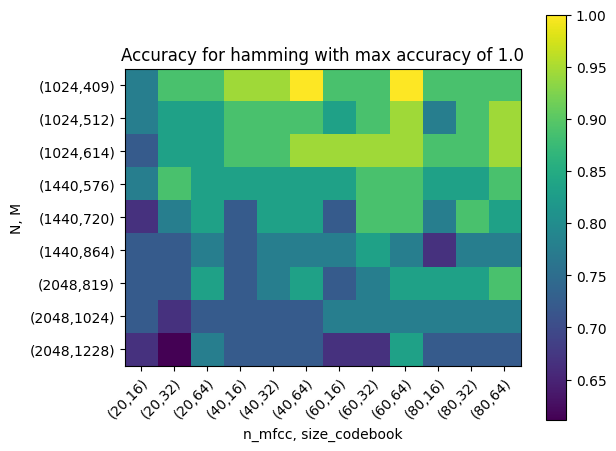

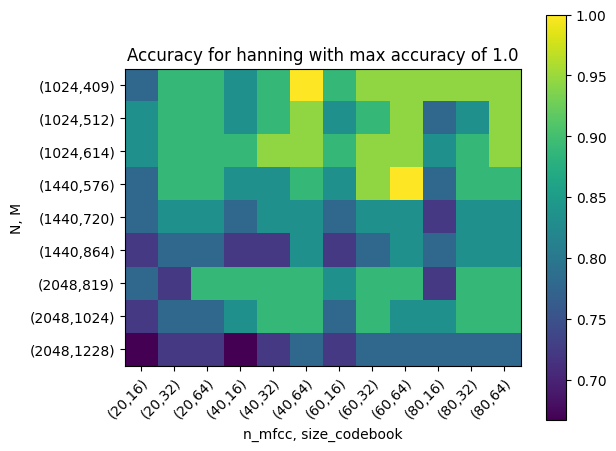

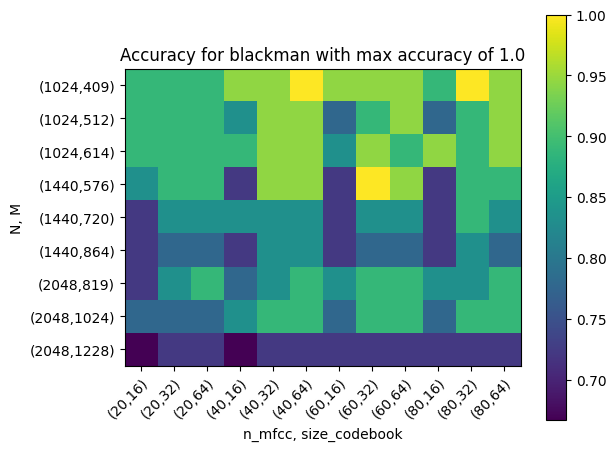

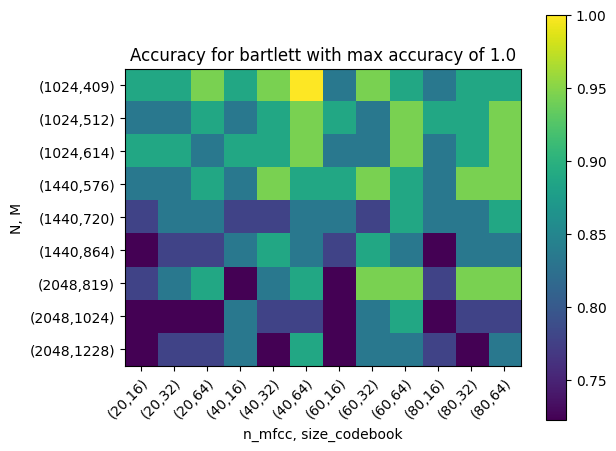

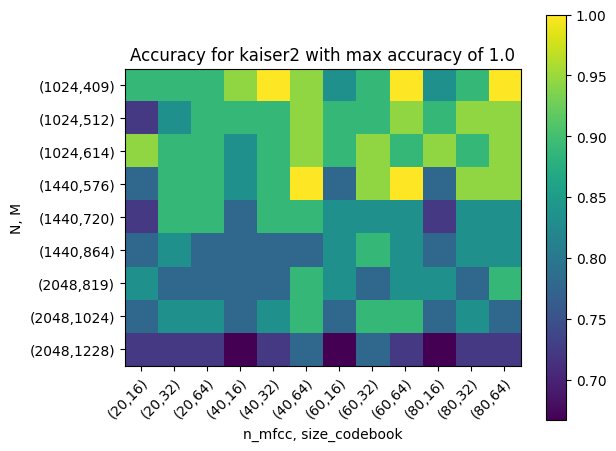

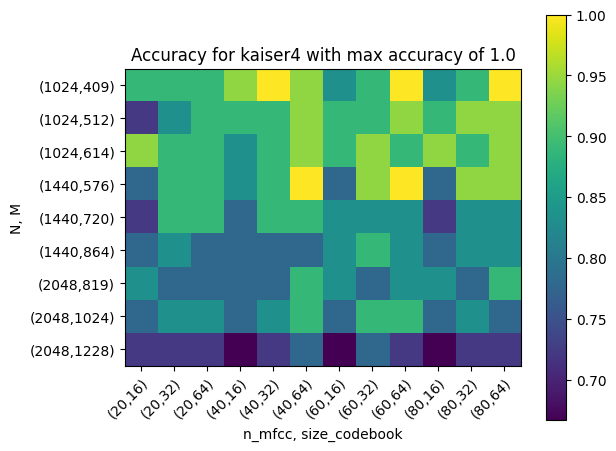

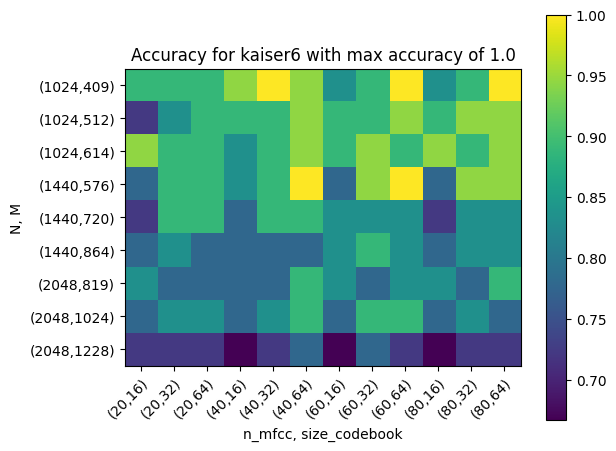

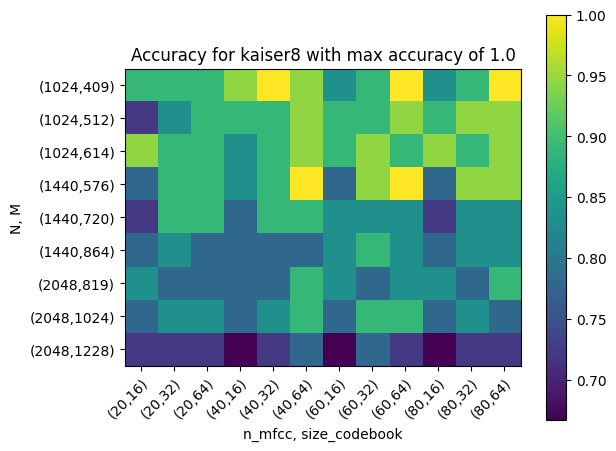

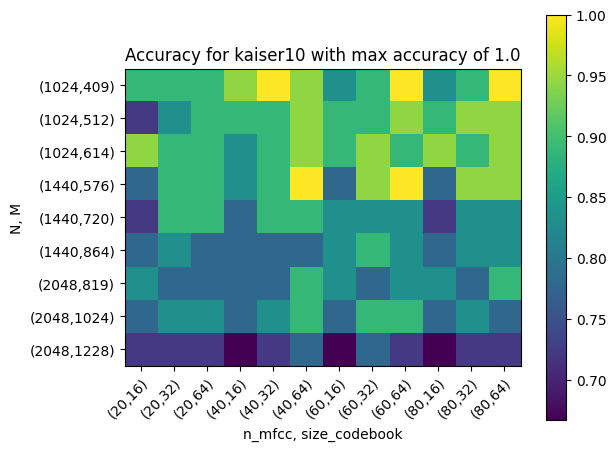

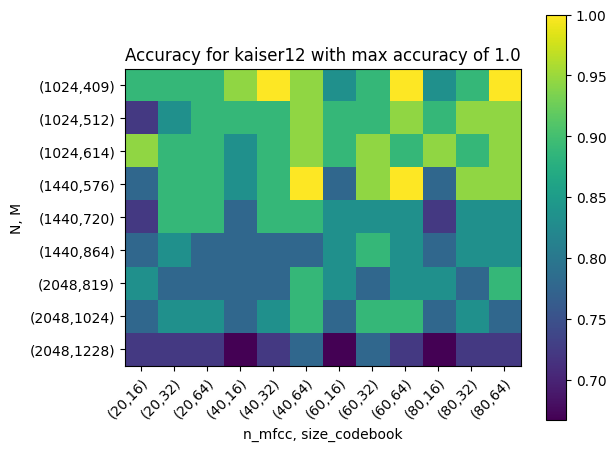

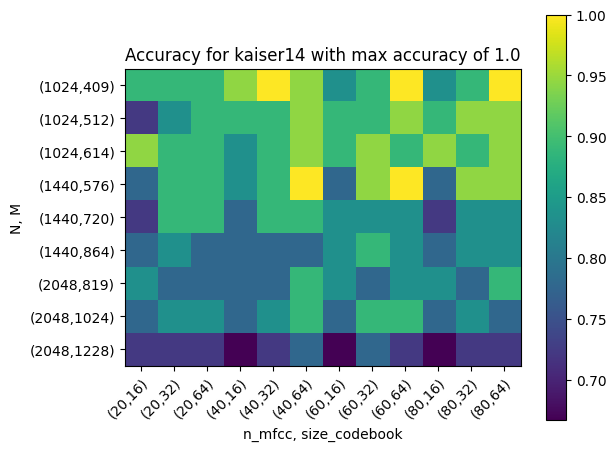

In [21]:
plot_accuracy(twelve_acc, N_list, M_list, n_mfcc_list, size_codebook_list)

#### Results for zero records

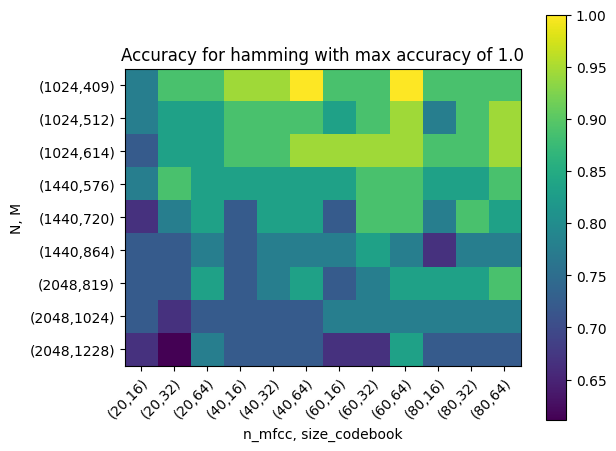

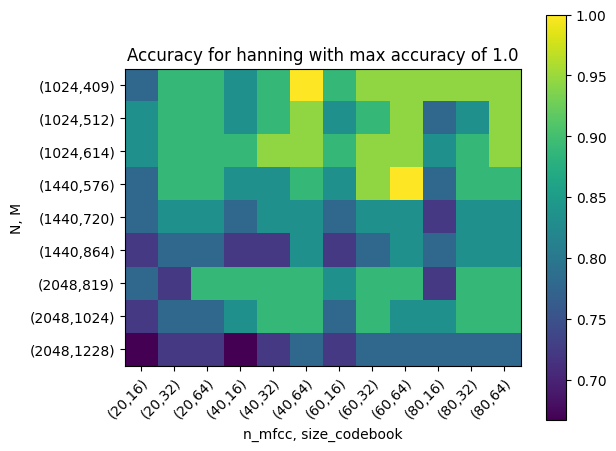

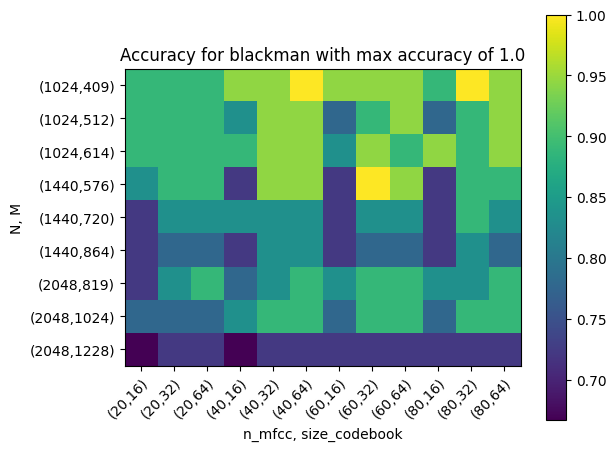

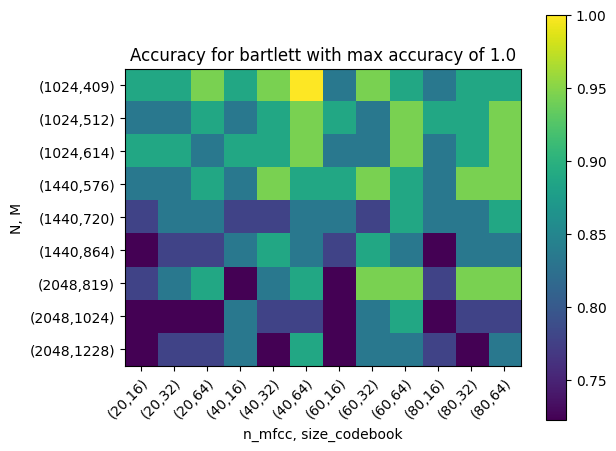

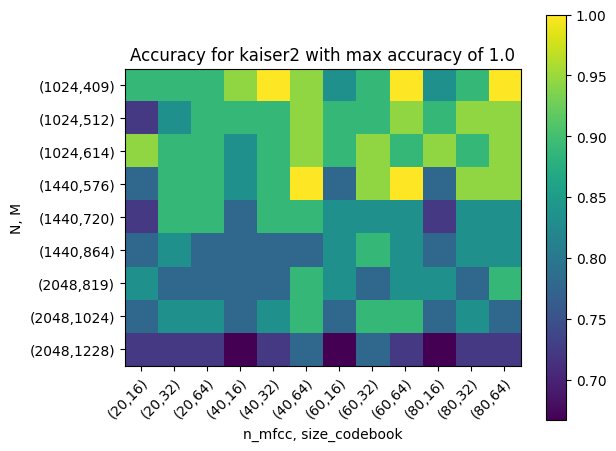

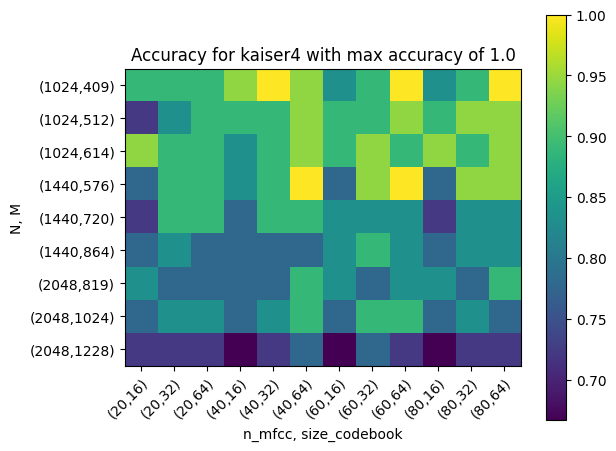

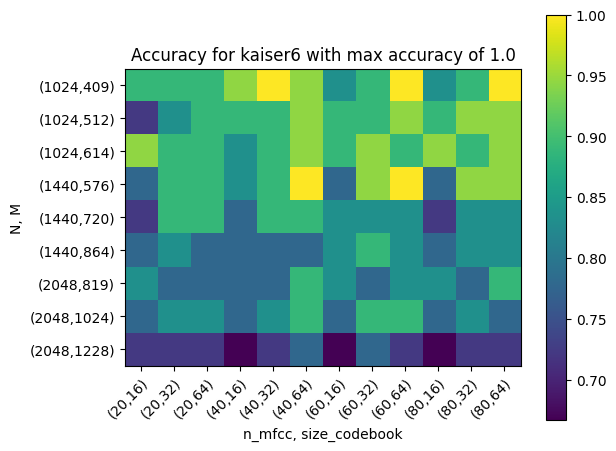

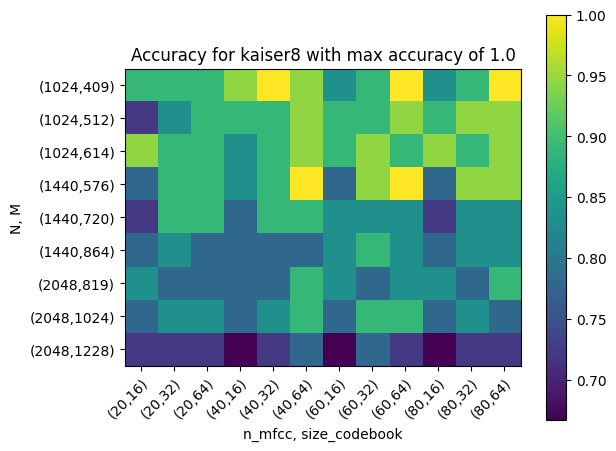

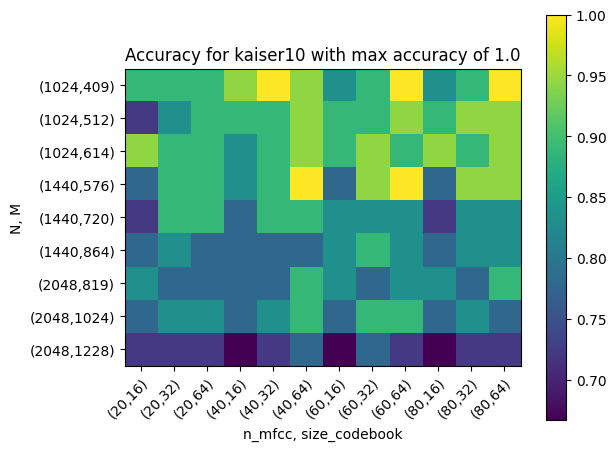

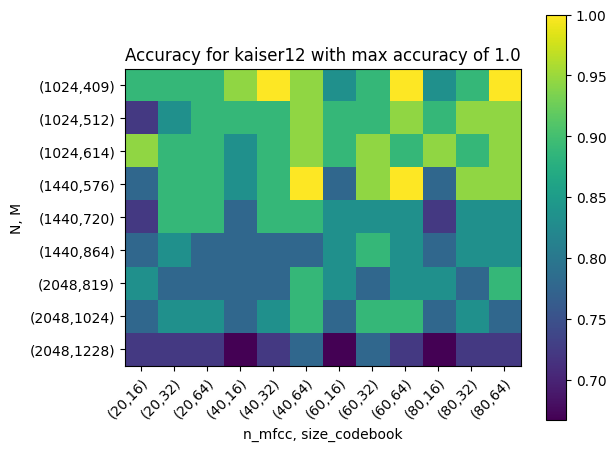

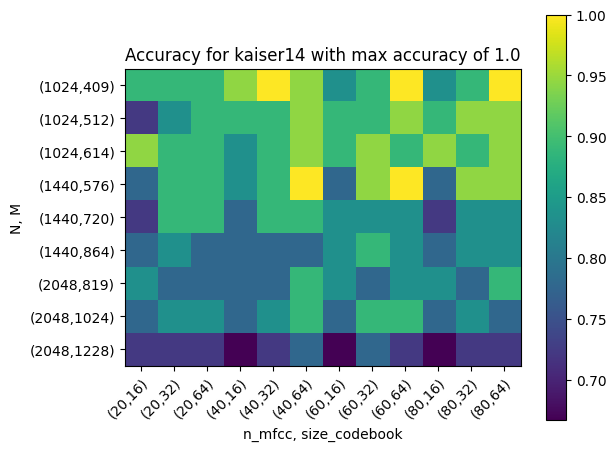

In [22]:
plot_accuracy(zero_acc, N_list, M_list, n_mfcc_list, size_codebook_list)